# 一、实验介绍
通过 torch.utils.data 加载数据，使用神经网络包 nn 和优化器 optm，创建一个神经网络。在 forward 方法中实现网络结构，采用预定义损失函数，进行迭代训练，查看网络的学习参数。


# 二、实验要求 
掌握通过Pytorch 实现BP神经网络的流程，掌握nn.Module 的继承和forward函数的实现方式，了解 Pytorch 常用的预定义损失函数，加深理解 AutoGrad 在神经网络中反向传播时的自动求导机制。

# 三、实验内容
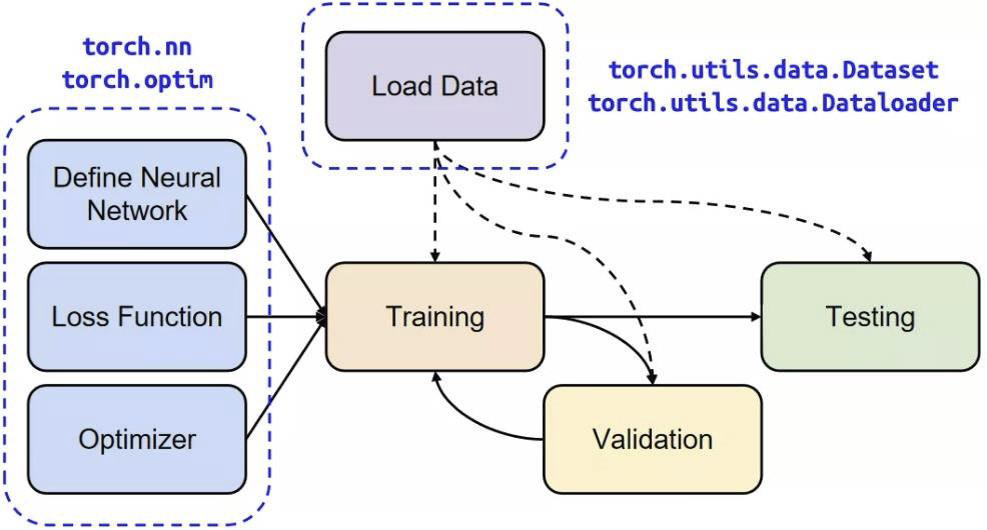

<center>图 1 Pytorch 常用工具箱使用的基本流程<center/>

## 3.1 实验数据集的加载及与预处理
本实验选取 Fashion-MNIST 作为实验数据集，是由 Zalando 旗下的研究部门提供。其涵盖了来自 10 种类别的共 7 万个不同商品的正面图片。Fashion-MNIST的大小、格式和训练集/测试集划分与原始的 MNIST 完全一致。60000/10000 的训练/测试数据划分，28x28 的灰度图片。


实验步骤：
### (1)利用`torchvision.transforms.Compose([……])`定义如下的变换：
1. 将shape=(H×W×C)且像素值范围为[0, 255]的图片数据转换成shape=(C×H×W)且像素值范围为[0.0, 1.0]的torch.FloatTensor；

2. 对训练数据进行规范化预处理（均值为0.5，方差为0.5）。


In [49]:
from torchvision import transforms
import torch

 # 创建Compose对象
transform_func_obj = transforms.Compose([
      transforms.ToTensor()
      # 1. 输入图像每个像素都归一化为[0.0, 1.0]
      # 2. 将这个图像转化为torch.tensor

    , transforms.Normalize((0.5, ), (0.5, ))
      # 1. 每个像素都会执行 pixel = (pixel - mean) / std
    ] 
    
    # 我们在compose初始化的时候，传入了一个list，其中包含两个对象，
    # 这两个对象在未来call这个函数对象的时候会被逐个作用在图片上
)

print(callable(transform_func_obj)) # 函数对象
print(type(transform_func_obj))


True
<class 'torchvision.transforms.transforms.Compose'>


## 加载数据集

1. 由于torchvision 自带 Fashion-MNIST 的接口，通过datasets.FashionMNIST()下载该数据集，并执行步骤（1）中定义的变换。
2. 利用DataLoader 设置训练集/测试集的批处理大小batch_size=256，并且对
数据进行打乱抽取，将设置完成的训练集/测试集命名为train_loader/ test_loader。

In [50]:
import torch.utils.data.dataloader
import torchvision
import torch

# 训练集
train_dataset = torchvision.datasets.FashionMNIST(root="./datasets/", 
                                      train=True, 
                                      transform=transform_func_obj,
                                      download=True)

# 测试集
test_dataset = torchvision.datasets.FashionMNIST(root="./datasets/",
                                     train=False,
                                     transform=transform_func_obj,
                                     download=True)


print(len(test_dataset))
print(len(train_dataset))

batch_size = 64
epochs = 3
my_lr = 0.01

train_data_loader = torch.utils.data.DataLoader(train_dataset, 
                                                batch_size=batch_size,
                                                shuffle=True)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               shuffle=True)



10000
60000


打印数据集

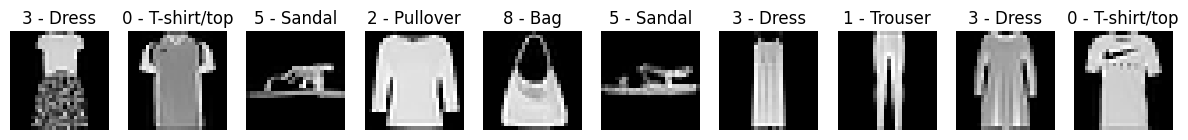

In [51]:
import matplotlib.pyplot as plt
import numpy as np

fashion_classes = torchvision.datasets.FashionMNIST.classes

# 从 train_data_loader 获取一个 batch 的数据
images, labels = next(iter(train_data_loader))

# 反归一化操作：由于 transforms.Normalize((0.5,), (0.5,)) 的变换公式为：
# pixel = (pixel - 0.5) / 0.5, 因此反归一化为：pixel = pixel * 0.5 + 0.5
images = images * 0.5 + 0.5

# 显示前 10 张图像
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    ax = axes[i]
    # FashionMNIST 是灰度图像，使用 squeeze() 去掉 channel 维度
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"{labels[i]} - {fashion_classes[labels[i]]}")
    ax.axis('off')
plt.show()


## 3.2 神经网络模型的构建
本实验基于全连接神经网络设计一个简单的分类器，实现对Fashion-MNIST
数据集的分类，如下图所示为对应的网络框架。
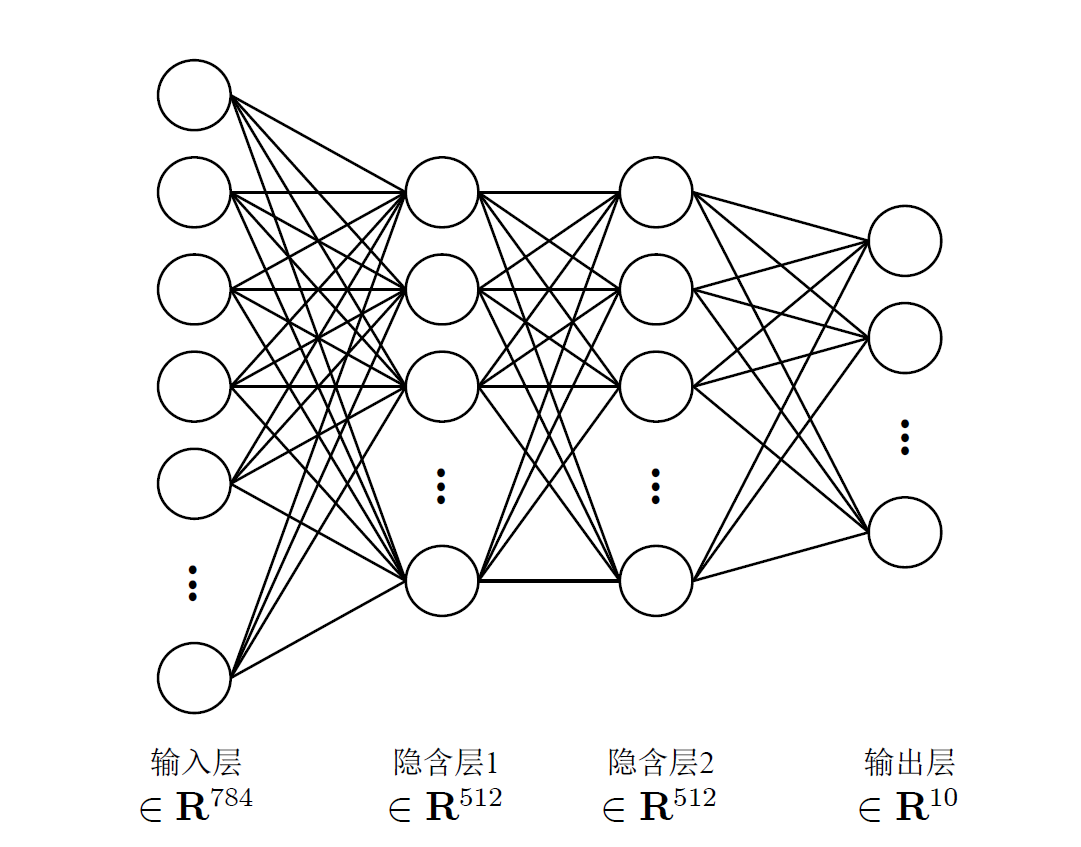
<center>图3 全连接神经网络框架图<center/>


步骤：
1. 利用 torch.nn 工具箱完成对上图全连接神经网络的定义，
2. 其中输入层神经元的个数为784（对应单个样本像素个数为28*28=784）
2. 中间两个隐含层的神经元个数为512，输出层神经元的个数为10（对应样本类别为10类）
3. 使用ReLU作为激活函数。

In [52]:
import torch

class MySimpleClassifier(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super(MySimpleClassifier, self).__init__(*args, **kwargs)
        self.fully_connected_layer_1 = torch.nn.Linear(28 * 28, 512)
        self.relu_1                  = torch.nn.ReLU  ()        
        self.fully_connected_layer_2 = torch.nn.Linear(512, 512)
        self.relu_2                  = torch.nn.ReLU  ()
        self.fully_connected_layer_3 = torch.nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.fully_connected_layer_1(x)
        x = self.relu_1(x)
        x = self.fully_connected_layer_2(x)
        x = self.relu_2(x)
        x = self.fully_connected_layer_3(x)
        return x

## 3.3 损失函数及优化器定义
实验步骤：
将模型的损失函数 loss_function 定义为交叉熵损失，

### 交叉熵损失函数（Cross-Entropy Loss）

对于二分类问题，假设：
- 真实标签 $ y $ 取值为 0 或 1
- 预测概率 $ \hat{y} $ 代表样本属于类别 1 的概率

则 **交叉熵损失** 定义为：
$$
L = - \left[ y \log \hat{y} + (1 - y) \log (1 - \hat{y}) \right]
$$

该公式的直觉：
- 如果 $ y = 1 $，那么损失变成 $ -\log \hat{y} $，即模型预测 $ \hat{y} $ 越接近 1，损失越小。
- 如果 $ y = 0 $，那么损失变成 $ -\log (1 - \hat{y}) $，即模型预测 $ \hat{y} $ 越接近 0，损失越小。

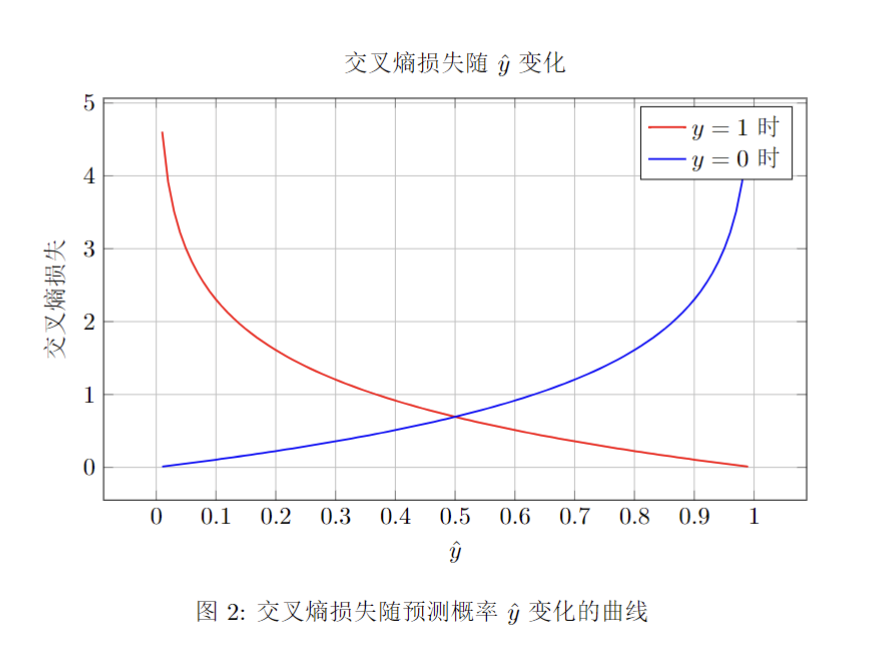

对于 **多分类问题（多类别独热编码）**，假设：
- 真实标签为 $ y $（独热编码）
- 预测概率分布为 $ \hat{y} $（经过 softmax 归一化）

则交叉熵损失定义为：
$$
L = - \sum_{i=1}^{C} y_i \log \hat{y}_i
$$
其中：
- $ C $ 是类别数
- $ y_i $ 只有一个值为 1，其余为 0
- 仅有真实类别对应的 $ \log \hat{y}_i $ 被计算到损失中

### Adam 优化器（Adaptive Moment Estimation）
Adam 是一种结合 **动量法（Momentum）** 和 **RMSProp** 优势的优化算法，其更新方式如下：

Adam 使用了一阶矩估计（动量）和二阶矩估计（均方根），分别表示为：
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$
其中：
- $ g_t $ 是梯度 $ \nabla_{\theta} J(\theta) $
- $ m_t $ 是梯度的 **一阶矩估计**（动量），类似于 **加权平均梯度，比如历史梯度权重0.9，当前batch的梯度0.1**
- $ v_t $ 是梯度的 **二阶矩估计**（均方梯度），类似于 **调整学习率，因为这个数会称为学习率的系数**
- $ \beta_1, \beta_2 $ 是衰减超参数（通常 $ \beta_1 = 0.9, \beta_2 = 0.999 $）

由于 $ m_t $ 和 $ v_t $ 初始值为 0，因此进行 **偏差修正**：
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

最后，更新参数：
$$
\theta_t = \theta_{t-1} - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
$$
其中：
- $ \alpha $ 是学习率
- $ \epsilon $ 是防止除零的小数（如 $ 10^{-8} $）

**直观理解**：
1. **动量项（$ m_t $）**：累积过去的梯度信息，使梯度更新方向更加稳定。
2. **均方根项（$ v_t $）**：动态调整学习率，使梯度下降更平稳，避免梯度爆炸或梯度消失。
3. **偏差修正**：克服初始时刻的一阶和二阶矩估计偏差，提高训练稳定性。

Adam 结合了 SGD 的高效性和自适应调整学习率的能力，适用于大多数深度学习任务。



并定义优化器optimizer为Adam。

In [53]:
import torch

model = MySimpleClassifier()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=my_lr)

for param in model.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([512, 784])
<class 'torch.nn.parameter.Parameter'> torch.Size([512])
<class 'torch.nn.parameter.Parameter'> torch.Size([512, 512])
<class 'torch.nn.parameter.Parameter'> torch.Size([512])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 512])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


## 3.4 在训练数据集上执行模型训练
实验步骤：
将 Epoch 次数定为20，开始训练模型，并打印每次Epoch 的模型损失。

In [54]:
# 训练前检查设备

# 1. 检查CUDA是否可用
print(f"CUDA是否可用: {torch.cuda.is_available()}")

# 2. 查看当前设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前设备: {device}")

# 3. 查看torch版本和配置
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA版本: {torch.version.cuda}")

# 4. GPU设备信息
if torch.cuda.is_available():
    print(f"GPU数量: {torch.cuda.device_count()}")
    print(f"当前GPU名称: {torch.cuda.get_device_name(0)}")
    print(f"当前GPU显存总量: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.0f}MB")
    print(f"当前GPU显存占用: {torch.cuda.memory_allocated(0) / 1024**2:.1f}MB")
    print(f"当前GPU显存缓存: {torch.cuda.memory_reserved(0) / 1024**2:.1f}MB")


CUDA是否可用: True
当前设备: cuda
PyTorch版本: 2.5.1
CUDA版本: 11.8
GPU数量: 1
当前GPU名称: NVIDIA GeForce RTX 3060 Laptop GPU
当前GPU显存总量: 6144MB
当前GPU显存占用: 0.0MB
当前GPU显存缓存: 0.0MB


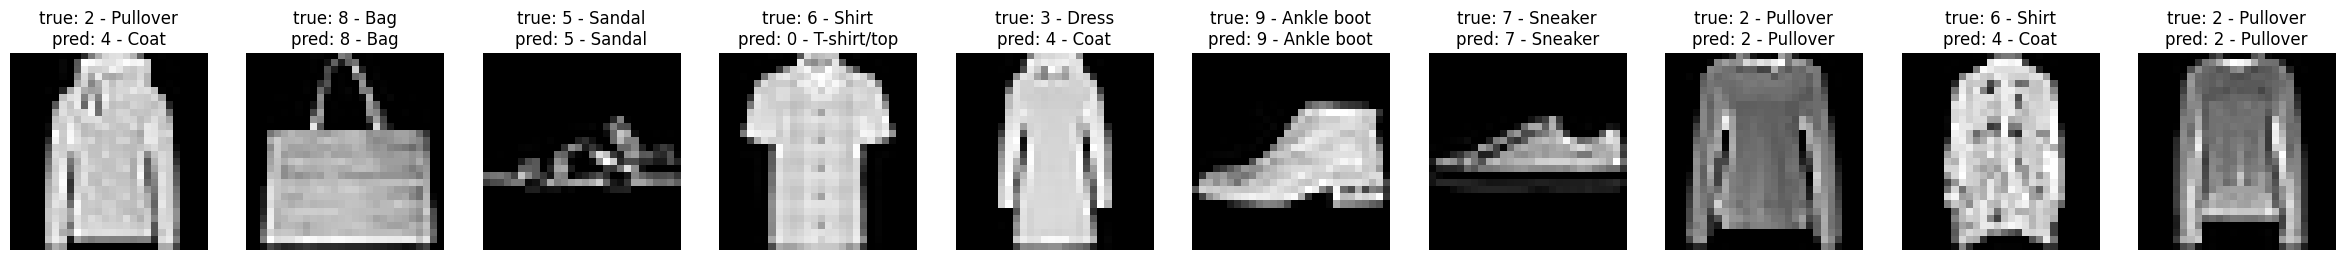

Test done! Accuracy (first batch): 81.0000%


In [74]:
# 训练模型
def train():
    for cur_epoch in range(epochs): # range的返回值从0开始
        total_loss = 0

        # 完整地把所有图片都用于训练一次
        for(images, lables) in train_data_loader:
            # 1. 前向传播
            outputs = model(images)
            loss = criterion(outputs, lables)
            
            # 2. 反向传播
            optimizer.zero_grad() # 优化器的梯度置零
            loss.backward() # 反向传播
            optimizer.step()

            total_loss += loss.item()
        
        print(f"Epoch [{cur_epoch}/{epochs}], total loss：{total_loss/len(train_data_loader):.4f}")

def test():
    correct_count = 0
    total_count = 0
    
    # 遍历整个 test_data_loader 计算准确率
    for idx, (images, labels) in enumerate(test_data_loader):
        # 不需要记录梯度
        with torch.no_grad():
            outputs = model(images)  # 前向传播
            _, predicted = torch.max(outputs, 1)
            total_count += images.size()[0]
            correct_count += (predicted == labels).sum().item()


        # 第一个batch的前十个图像打印具体信息
        if idx == 0:
            # 图像经过 Normalize((0.5,), (0.5,))，反归一化以便显示
            images = images * 0.5 + 0.5
            
            # 创建1行10列的图像展示
            fig, axes = plt.subplots(1, 10, figsize=(30, 3))
            for i in range(10):
                axes[i].imshow(images[i].squeeze(), cmap='gray')
                axes[i].set_title(f"true: {labels[i].item()} - {fashion_classes[labels[i].item()]}\npred: {predicted[i].item()} - {fashion_classes[predicted[i].item()]}")
                axes[i].axis('off')
            plt.show()
    
    
    print(f"Test done! Accuracy (first batch): {100 * correct_count / total_count:.4f}%")


# train()
test()

# 四、python语法
## 语法补充：python的for循环
1. for in语句的底层工作原理
2. 可迭代对象的必要条件
3. 相关魔术方法的实现

### 解释:
for in 循环的本质是调用以下两个方法:
1. `__iter__()`: 返回迭代器对象
2. `__next__()`: 获取下一个值直到抛出 StopIteration 异常

### 代码示例:



In [56]:
# 自定义可迭代对象
class MyRange:
    def __init__(self, n):
        self.n = n
        self.current = 0
    
    def __iter__(self):  # 返回迭代器对象
        return self
    
    def __next__(self):  # 实现迭代逻辑
        if self.current < self.n:
            result = self.current
            self.current += 1
            return result
        raise StopIteration

# 使用示例
for i in MyRange(3):
    print(i)  # 输出: 0, 1, 2

# 等价于:
iterator = iter(MyRange(3))  # 调用__iter__()
while True:
    try:
        i = next(iterator)   # 调用__next__()
        print(i)
    except StopIteration:
        break

0
1
2
0
1
2




关键点:
- in 后面的对象必须实现 `__iter__()` 方法
- 迭代器必须实现 `__next__()` 方法
- `__iter__()` 可以返回自身或新的迭代器对象

# 五、实验总结

## 1. 前向传播与反向传播（链式求导）

### 前向传播  
- **过程**：输入数据通过神经网络的各层（例如线性变换加激活函数）逐层传递，最终产生输出。  
- **例子**：假设有一个简单的两层网络：
  $$
  \begin{aligned}
  \textbf{z}^{(1)} &= W^{(1)} \textbf{x} + b^{(1)}, 
  \quad 
  \textbf{a}^{(1)} = \text{ReLU}\bigl(\textbf{z}^{(1)}\bigr), \\
  \textbf{z}^{(2)} &= W^{(2)} \textbf{a}^{(1)} + b^{(2)}.
  \end{aligned}
  $$
  此处，$\textbf{z}^{(2)}$ 是输出（例如分类前的 logits）。

### 反向传播与链式求导  
- **基本思想**：利用链式法则，从输出层向输入层逐层计算损失函数对每个参数的梯度。  
- **公式**：例如，对于一层线性变换 $ \textbf{z} = W \textbf{x} + b $ 和激活函数 $ \textbf{a} = f(\textbf{z}) $，如果损失 $L$ 是关于 $\textbf{a}$ 的函数，则：
  $$
  \frac{\partial L}{\partial W} = \frac{\partial L}{\partial \textbf{a}} \cdot \frac{\partial \textbf{a}}{\partial \textbf{z}} \cdot \frac{\partial \textbf{z}}{\partial W}.
  $$
- **简单例子**：  
  对于线性回归，假设模型为
  $$
  \hat{y} = ax + b,
  $$
  损失函数用均方误差：
  $$
  L = \frac{1}{2} (\hat{y} - y)^2.
  $$
  则对参数 $a$ 的梯度为：
  $$
  \frac{\partial L}{\partial a} = (\hat{y} - y)x,
  $$
  对 $b$ 的梯度为：
  $$
  \frac{\partial L}{\partial b} = (\hat{y} - y).
  $$
  这就是链式求导在简单网络中的体现。

---

## 2. 交叉熵损失

### 定义与公式  
- **多分类问题**中，通常用交叉熵损失来衡量模型预测的概率分布与真实分布之间的差异：
  $$
  L = -\sum_{i=1}^{C} y_i \log (\hat{y}_i),
  $$
  其中：  
  - $C$ 为类别数；  
  - $y_i$ 是真实标签的 one-hot 编码（正确类别为 1，其余为 0）；  
  - $\hat{y}_i$ 是模型通过 softmax 得到的预测概率。

### 直观例子  
- **例子**：设有 3 个类别，真实标签为类别 2，对应 one-hot 编码为 $[0, 1, 0]$；  
  模型预测的概率为 $[0.2, 0.5, 0.3]$。  
  则交叉熵损失计算为：
  $$
  L = -\left(0 \times \log(0.2) + 1 \times \log(0.5) + 0 \times \log(0.3)\right) = -\log(0.5) \approx 0.6931.
  $$
- **说明**：  
  虽然公式中对所有类别求和，但在 one-hot 情况下，只有正确类别的那一项对损失有贡献；这种写法也方便扩展到标签平滑或软标签情况。

---

## 3. Adam 优化器

Adam 优化器结合了 **动量法** 和 **RMSProp** 的思想，其核心在于利用当前 batch 的梯度和历史梯度信息来更新参数。它的更新公式为：
$$
\theta_t = \theta_{t-1} - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon}\,\hat{m}_t.
$$

### 关键部分解释

1. **一阶矩（动量）**  
   $$
   m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t,
   $$
   这里 $g_t$ 是当前 batch 的梯度，$\beta_1$（常设为 0.9）控制了历史梯度与当前梯度的权重。通过偏差修正：
   $$
   \hat{m}_t = \frac{m_t}{1-\beta_1^t}.
   $$
   **直观**：$m_t$ 就像“记忆”一样累积过去的梯度，使更新方向更稳定。

2. **二阶矩（均方梯度）**  
   $$
   v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2,
   $$
   $\beta_2$（常设为 0.999）控制梯度平方的指数衰减。偏差修正后：
   $$
   \hat{v}_t = \frac{v_t}{1-\beta_2^t}.
   $$
   **直观**：$v_t$ 反映了梯度的“震荡”情况，通过分母 $\sqrt{\hat{v}_t}+\epsilon$ 调整每个参数的步长，避免梯度过大导致更新过猛。

3. **参数更新**  
   将自适应调整后的梯度用来更新参数：
   $$
   \theta_t = \theta_{t-1} - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon}\,\hat{m}_t.
   $$
   **说明**：  
   - 更新方向由 $\hat{m}_t$ 决定（“动量”效应），  
   - 更新步长则根据 $\sqrt{\hat{v}_t}$ 自适应调整。

### 简单数值例子  
假设某参数在连续 3 个 batch 中的梯度分别为：
- Batch 1: $g_1 = 0.8$
- Batch 2: $g_2 = 0.2$
- Batch 3: $g_3 = -0.5$

取 $\beta_1 = 0.9$，初始 $m_0 = 0$：
- Batch 1: $m_1 = 0.9 \times 0 + 0.1 \times 0.8 = 0.08$
- Batch 2: $m_2 = 0.9 \times 0.08 + 0.1 \times 0.2 = 0.092$
- Batch 3: $m_3 = 0.9 \times 0.092 + 0.1 \times (-0.5) \approx 0.0328$

可以看到，尽管某个 batch 的梯度变化较大，但累计的动量 $m_t$ 是平滑的，体现了历史梯度的影响。

---

## 总结

1. **反向传播与链式求导**：  
   - 前向传播将数据传递到网络各层，计算出输出和损失；  
   - 反向传播利用链式法则，从输出层向前依次计算每个参数对损失的梯度。

2. **交叉熵损失**：  
   - 用于多分类问题，衡量模型预测概率分布与真实标签分布的差异；  
   - 公式为 $L = -\sum_{i=1}^{C} y_i \log (\hat{y}_i)$，在 one-hot 标签下只有正确类别的概率起作用。

3. **Adam 优化器**：  
   - 通过计算梯度的一阶矩（动量）和二阶矩（梯度平方的加权平均）来平滑梯度信息；  
   - 公式为  
     $$
     \theta_t = \theta_{t-1} - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon}\,\hat{m}_t,
     $$
     其中 $\hat{m}_t$ 和 $\hat{v}_t$ 分别为偏差修正后的一阶和二阶矩。

可以对深度学习中的前向传播、反向传播（链式求导）、交叉熵损失及 Adam 优化器有一个清晰的认识，并能在纸上推导每一步的公式，体会它们的数学本质。